# Goals

* Create a pipeline to gather new datasets from GEO and SRA

# Init

In [1]:
import os
import operator
from enum import Enum
from functools import partial
from pprint import pprint
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any, Sequence, TypedDict
from pydantic import BaseModel, Field
from Bio import Entrez
import pandas as pd
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.graph import START, END, StateGraph
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage


In [2]:
from SRAgent.tools.esearch import esearch_scrna
from SRAgent.agents.convert import create_convert_graph, invoke_convert_graph
from SRAgent.agents.metadata import OrganismEnum, YesNo, create_metadata_graph, invoke_metadata_graph, get_metadata_items
from SRAgent.agents.entrez import create_entrez_agent

In [3]:
# setup
load_dotenv()
pd.set_option('display.max_colwidth', 1000)
os.environ["DEBUG_MODE"] = "TRUE"

In [4]:
# checks
if os.getenv("DEBUG_MODE") == "TRUE":
    print("DEBUG_MODE is enabled.")

DEBUG_MODE is enabled.


In [5]:
# set up Entrez
Entrez.email = "nick.youngblut@arcinstitute.org"
Entrez.api_key = os.getenv("NCBI_API_KEY")

# State

In [29]:
class GraphState(TypedDict):
    SRX: Annotated[List[str], "SRX accession to query"]
    is_illumina: Annotated[str, "Is Illumina sequence data?"]
    is_single_cell: Annotated[str, "Is single cell RNA-seq data?"]
    is_paired_end: Annotated[str, "Is paired-end sequencing data?"]
    is_10x: Annotated[str, "Is 10X Genomics data?"]
    organism: Annotated[str, "Organism sequenced"]
    messages: Annotated[Sequence[BaseMessage], operator.add]

# Tools

In [30]:
@tool
def invoke_entrez_worker(
    message: str,
):
    """
    Invoke the Entrez worker.
    The Entrez worker can be used to query the NCBI Entrez database.
    """
    entrez_agent = create_entrez_agent()
    response = entrez_agent.invoke({"messages" : [HumanMessage(content=message)]})
    return {"messages" : [response["messages"][-1]]}

In [31]:
model = ChatOpenAI(model="gpt-4o")

In [32]:

researcher_agent = create_react_agent(
    model=model,
    tools=[invoke_entrez_worker],
    state_modifier="\n".join([
        "You are a helpful bioinformatician assisting a researcher with a task involving Entrez databases.",
        "You will be provided with a dataset Entrez ID from the Sequence Read Archive (SRA) database.",
        "Your task:",
        " 1. Obtain all SRX accessions (SRA Experiment accessions) for the dataset.",
        " 2. For each SRX accession, obtain the following metadata:"
        "    - Is Illumina sequence data?",
        "    - Is paired-end sequencing data?",
        "    - Is single cell RNA-seq data?",
        "    - Is 10X Genomics data?",
        "    - Organism sequenced",
        "\n"
        "Continue calling the Entrez worker until all SRX accessions have been processed and metadata obtained.",
        "Be concise and do not include unnecessary wording."
    ])
)

In [33]:
# invoke the agent
inputs = {"messages": [("user", "Entrez ID: 36185246")]}
config = {"max_concurrency" : 3, "recursion_limit": 100}
#for step in researcher_agent.stream(inputs, stream_mode="values", config=config):
#    print(step)

In [34]:

evaluator_agent = create_react_agent(
    model=model,
    tools=[invoke_entrez_worker],
    state_modifier="\n".join([
        "You are a helpful senior bioinformatician assisting a researcher with a task involving Entrez databases.",
        "You will be provided with results from the researcher tasked with the following:",
        "#-- The task --#",
        "Given a dataset Entrez ID from the Sequence Read Archive (SRA) database, do the following:",
        " 1. Obtain all SRX accessions (SRA Experiment accessions) for the dataset.",
        " 2. For each SRX accession, obtain the following metadata:"
        "    - Is Illumina sequence data?",
        "    - Is paired-end sequencing data?",
        "    - Is single cell RNA-seq data?",
        "    - Is 10X Genomics data?",
        "    - Organism sequenced",
        "#--------------#",
        "Evaluate whether all of the data has been obtained.",
        "For instance, you can double check that all SRX accessions have been obtained.",
        "If data appears to be missing or incorrect, call the Entrez worker to obtain the required data.",
        "Keep calling the Entrez worker until all required data has been obtained.",
        "Be concise and to not include helpful wording."
    ])
)

### Data extraction

In [35]:
class YesNo(Enum):
    """
    Yes, no, or unsure
    """
    YES = "yes"
    NO = "no"
    UNSURE = "unsure"

class OrganismEnum(Enum):
    """
    Organism sequenced
    """
    HUMAN = "human"
    MOUSE = "mouse"
    RAT = "rat"
    MONKEY = "monkey"
    HORSE = "horse"
    DOG = "dog"
    BOVINE = "bovine"
    CHICKEN = "chicken"
    SHEEP = "sheep"
    PIG = "pig"
    FRUIT_FLY = "fruit_fly"
    ROUNDWORM = "roundworm"
    ZEBRAFISH = "zebrafish"
    OTHER = "other"

class MetadataEnum(BaseModel):
    """
    Metadata to extract
    """
    SRX_accessions: List[str]
    is_illumina: YesNo
    is_single_cell: YesNo
    is_paired_end: YesNo
    is_10x: YesNo
    organism: OrganismEnum

In [36]:
def get_metadata_items():
    metadata_items = [
        " - Is the study Illumina sequence data?",
        " - Is the study Illumina sequence data?",
        " - Is the study single cell RNA-seq data?",
        " - Is the study paired-end sequencing data?",
        " - Is the study 10X Genomics data?",
        " - Which organism was sequenced?"
    ]
    return metadata_items

In [ ]:
def create_get_metadata_node():
    model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

    def invoke_get_metadata_node(state: GraphState):
        """
        Structured data extraction
        """
        # create prompt
        prompt = "\n".join([
            "Your job is to extract metadata from the provided text on a Sequence Read Archive (SRA) experiment.",
            "If there is not enough information to determine the metadata, please respond with 'unsure'.",
            "The specific metadata to extract:"] + get_metadata_items())

        prompt = ChatPromptTemplate.from_messages([
            # First add any static system message if needed
            ("system", prompt),
            ("system", "\nHere are the last few messages:"),
            MessagesPlaceholder(variable_name="history")
        ])
        prompt = prompt.format_messages(history=state["messages"])

        # invoke model
        model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
        response = model.with_structured_output(MetadataEnum, strict=True).invoke(prompt)

        # return response to state
        return {
            "SRX" : response.SRX_accessions,
            "is_illumina" : response.is_illumina.value,
            "is_paired_end" : response.is_paired_end.value,
            "is_single_cell" : response.is_single_cell.value,
            "is_10x" : response.is_10x.value,
            "organism" : response.organism.value
        }
    
    return invoke_get_metadata_node

# Graph

In [38]:
#-- graph --#
workflow = StateGraph(GraphState)

# nodes
workflow.add_node("researcher_node", researcher_agent)
workflow.add_node("evaluator_node", evaluator_agent)
workflow.add_node("get_metadata_node", create_get_metadata_node())

# edges
workflow.add_edge(START, "researcher_node")
workflow.add_edge("researcher_node", "evaluator_node")
workflow.add_edge("evaluator_node", "get_metadata_node")
workflow.add_edge("get_metadata_node", END)

# compile the graph
graph = workflow.compile()

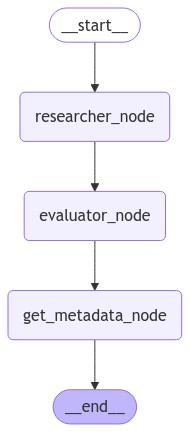

In [39]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [40]:
# invoke the graph
entrez_id = "36185246"
inputs = {"messages": [("user", f"Entrez ID: {entrez_id}")]}
config = {"max_concurrency" : 3, "recursion_limit": 100}
final_state = None
for step in graph.stream(inputs, subgraphs=True, stream_mode="values", config=config):
    print(step)
    final_state = step

((), {'messages': [('user', 'Entrez ID: 36185246')]})
(('researcher_node:e38be142-16f0-8ebf-92b7-3be33d938deb',), {'messages': [HumanMessage(content='Entrez ID: 36185246', additional_kwargs={}, response_metadata={}, id='16f78f1b-5f25-44fa-b0cb-f51befba5fdc')]})
(('researcher_node:e38be142-16f0-8ebf-92b7-3be33d938deb',), {'messages': [HumanMessage(content='Entrez ID: 36185246', additional_kwargs={}, response_metadata={}, id='16f78f1b-5f25-44fa-b0cb-f51befba5fdc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Ft9NawovoI3LVS13kOPSpCdQ', 'function': {'arguments': '{"message":"Fetch SRX accessions for Entrez ID: 36185246 in the SRA database."}', 'name': 'invoke_entrez_worker'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 219, 'total_tokens': 254, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_toke

In [41]:
# Convert to state to dataframe
to_keep = ["SRX", "is_illumina", "is_paired_end", "is_single_cell", "is_10x", "organism"]
df = {"entrez_id" : entrez_id}
for x in to_keep:
    df[x] = final_state[1][x]
df = pd.DataFrame(df)
df

,entrez_id,SRX,is_illumina,is_paired_end,is_single_cell,is_10x,organism
0,36185246,SRX26777130,yes,yes,yes,yes,human


In [42]:
# invoke the graph
entrez_id = "34747624"
inputs = {"messages": [("user", f"Entrez ID: {entrez_id}")]}
config = {"max_concurrency" : 3, "recursion_limit": 100}
final_state = None
for step in graph.stream(inputs, subgraphs=True, stream_mode="values", config=config):
    print(step)
    final_state = step

((), {'messages': [('user', 'Entrez ID: 34747624')]})
(('researcher_node:0b07c3b5-5c7c-784c-158f-36a7afb49db3',), {'messages': [HumanMessage(content='Entrez ID: 34747624', additional_kwargs={}, response_metadata={}, id='1bacb5f7-143f-40ab-9b5e-3d07ef639748')]})


(('researcher_node:0b07c3b5-5c7c-784c-158f-36a7afb49db3',), {'messages': [HumanMessage(content='Entrez ID: 34747624', additional_kwargs={}, response_metadata={}, id='1bacb5f7-143f-40ab-9b5e-3d07ef639748'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8CkRGnaAOqUdEIfM7nQOpBHe', 'function': {'arguments': '{"message":"Retrieve all SRX accessions for Entrez ID 34747624 from the SRA database."}', 'name': 'invoke_entrez_worker'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 219, 'total_tokens': 254, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b23f6363-24bf-4d08-b8c8-78e003edd9ce-0', tool_calls=[{'name': 'invo

In [43]:
# Convert to state to dataframe
to_keep = ["SRX", "is_illumina", "is_paired_end", "is_single_cell", "is_10x", "organism"]
df = {"entrez_id" : entrez_id}
for x in to_keep:
    df[x] = final_state[1][x]
df = pd.DataFrame(df)
df

,entrez_id,SRX,is_illumina,is_paired_end,is_single_cell,is_10x,organism
0,34747624,SRX25716879,yes,yes,yes,yes,mouse


In [44]:
# invoke the graph
entrez_id = "36178521"
inputs = {"messages": [("user", f"Entrez ID: {entrez_id}")]}
config = {"max_concurrency" : 3, "recursion_limit": 100}
final_state = None
for step in graph.stream(inputs, subgraphs=True, stream_mode="values", config=config):
    print(step)
    final_state = step

((), {'messages': [('user', 'Entrez ID: 36178521')]})
(('researcher_node:7838f859-b5db-9198-b476-b5cc0149fc8c',), {'messages': [HumanMessage(content='Entrez ID: 36178521', additional_kwargs={}, response_metadata={}, id='d645c079-f990-491b-af23-ca4506bce231')]})
(('researcher_node:7838f859-b5db-9198-b476-b5cc0149fc8c',), {'messages': [HumanMessage(content='Entrez ID: 36178521', additional_kwargs={}, response_metadata={}, id='d645c079-f990-491b-af23-ca4506bce231'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9CYc4SC7bkzckM1DlWYTmndV', 'function': {'arguments': '{"message":"Fetch all SRX accessions for Entrez ID 36178521 from the SRA database."}', 'name': 'invoke_entrez_worker'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 219, 'total_tokens': 254, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt

In [45]:
# Convert to state to dataframe
to_keep = ["SRX", "is_illumina", "is_paired_end", "is_single_cell", "is_10x", "organism"]
df = {"entrez_id" : entrez_id}
for x in to_keep:
    df[x] = final_state[1][x]
df = pd.DataFrame(df)
df

,entrez_id,SRX,is_illumina,is_paired_end,is_single_cell,is_10x,organism
0,36178521,ERX11887199,yes,yes,yes,yes,mouse
